In [1]:
from pyspark.sql import SparkSession
import json

In [6]:
with open("../config/spark_config.json", "r") as f:
    config = json.load(f)

In [7]:
spark = SparkSession.builder \
    .appName(config["spark"]["appName"]) \
    .config("spark.hadoop.fs.defaultFS", config["spark"]["hadoop"]["fs.defaultFS"]) \
    .config("spark.hadoop.hadoop.home.dir", config["spark"]["hadoop"]["home.dir"]) \
    .config("spark.executor.memory", config["spark"]["memory"]["executor"]) \
    .config("spark.driver.memory", config["spark"]["memory"]["driver"]) \
    .getOrCreate()

25/01/11 15:57:09 WARN Utils: Your hostname, Ala resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/01/11 15:57:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/11 15:57:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
spark

In [10]:
path="hdfs://172.18.0.2:9000/user/ala/uniprot_data_first_3000.tsv"
protein_df  = spark.read.option("header","true")\
                    .option("sep", "\t")\
                    .option("multiLine", "true")\
                    .option("quote","\"")\
                    .option("escape","\"")\
                    .option("ignoreTrailingWhiteSpace", True)\
                    .csv(path)

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
from collections import defaultdict

In [12]:
protein_df.show(50)

+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|     Entry|  Reviewed|      Entry Name|       Protein names|          Gene Names|            Organism|Length|            Sequence|           EC number|            InterPro|
+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|A0A024R1X5|unreviewed|A0A024R1X5_HUMAN|            Beclin-1|     BECN1 hCG_16958|Homo sapiens (Human)|   450|MEGSKTSNNSTMQVSFV...|                NULL|IPR007243;IPR0382...|
|A0A024R274|unreviewed|A0A024R274_HUMAN|Mothers against d...|               SMAD4|Homo sapiens (Human)|   552|MDNMSITNTPTSNDACL...|                NULL|IPR013790;IPR0036...|
|A0A024R324|unreviewed|A0A024R324_HUMAN|Transforming prot...|      RHOA hCG_20136|Homo sapiens (Human)|   193|MAAIRKKLVIVGDGACG...

In [13]:
protein_df_all = protein_df.filter(col("InterPro").isNotNull())

In [17]:
from pyspark.sql.functions import udf

In [19]:
split_domains_udf = udf(lambda x: x.split(";") if x else [], ArrayType(StringType()))

In [20]:

protein_df = protein_df_all.withColumn("domain_list", split_domains_udf(col("InterPro")))

In [49]:
# Fonction pour calculer la similarité de Jaccard
def jaccard_similarity(domains1, domains2):
    if domains1 is None or domains2 is None:
        return 0.0
    set1 = set(domains1)
    set2 = set(domains2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union

In [50]:
import itertools
# Fonction pour calculer la similarité de Jaccard sur des paires uniques
def calculate_jaccard_on_pairs(df, threshold):
    results = []
    
    # Collecter les données dans une liste
    protein_data = df.select("Entry", "domain_list").collect()
    
    # Générer des paires uniques avec itertools.combinations
    for (row1, row2) in itertools.combinations(protein_data, 2):
        domains1 = row1["domain_list"]
        domains2 = row2["domain_list"]
        
        similarity = jaccard_similarity(domains1, domains2)
        
        if similarity >= threshold:
            results.append((row1["Entry"], row2["Entry"], similarity))
    
    return results

In [54]:
# Calculer les similarités avec un seuil de 0.4
similarity_data = calculate_jaccard_on_pairs(protein_df, threshold=0.4)

In [55]:
len(similarity_data)

13955

In [59]:
test = similarity_data[:30]

In [60]:
import matplotlib.pyplot as plt
import networkx as nx

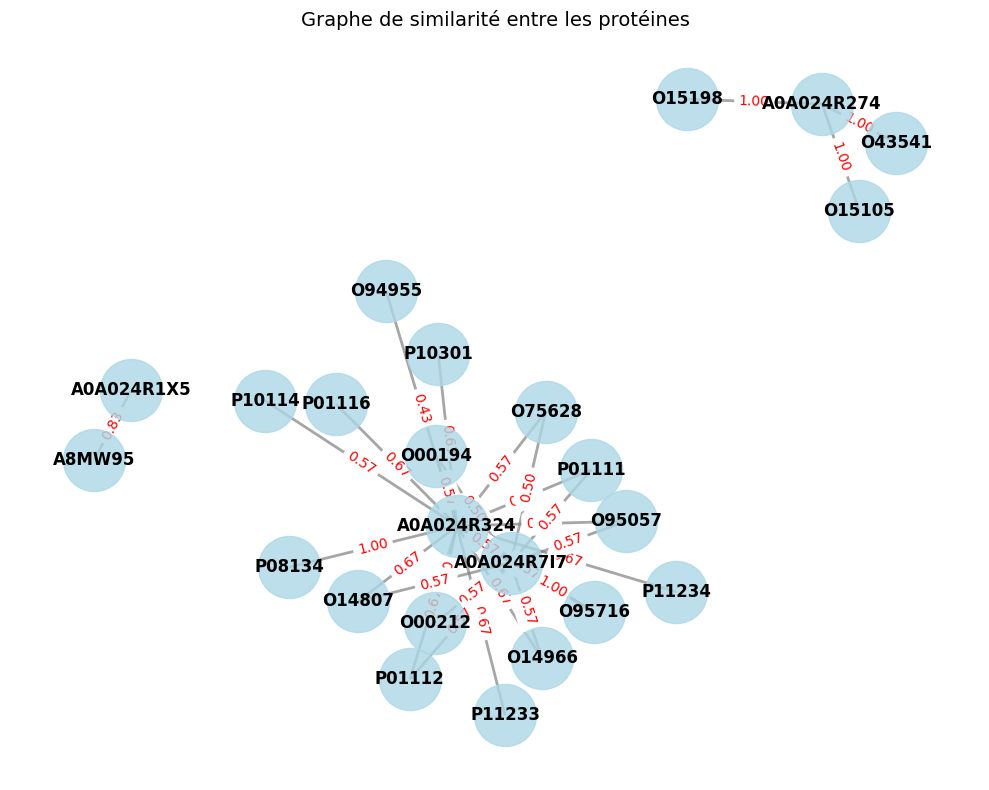

In [61]:
G = nx.Graph()

for edge in test:
    protein1, protein2, similarity = edge
    G.add_edge(protein1, protein2, weight=similarity)

pos = nx.spring_layout(G, k=0.5, iterations=50)

plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_family='sans-serif')

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

plt.title("Graphe de similarité entre les protéines", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
